In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_df_merged.csv')

In [3]:
df

,region_id,hour_start,alarm_minutes_in_hour,is_alarm_active,alarms_started_in_hour,time_since_last_alarm_end_minutes,date_value,time_value,dew,snow,...,svd_comp_144,svd_comp_145,svd_comp_146,svd_comp_147,svd_comp_148,svd_comp_149,svd_comp_150,hour_of_day,day_of_week,month
0,1,2022-02-24 00:00:00,0.000000,0,0,512149.350000,2022-02-24,00:00:00,0.9,0.0,...,-0.027000,-0.005885,0.027045,-0.031285,0.051623,0.007152,0.016031,0,3,2
1,2,2022-02-24 00:00:00,0.000000,0,0,512149.350000,2022-02-24,00:00:00,0.9,0.0,...,-0.027000,-0.005885,0.027045,-0.031285,0.051623,0.007152,0.016031,0,3,2
2,3,2022-02-24 00:00:00,0.000000,0,0,512149.350000,2022-02-24,00:00:00,0.9,0.0,...,-0.027000,-0.005885,0.027045,-0.031285,0.051623,0.007152,0.016031,0,3,2
3,4,2022-02-24 00:00:00,0.000000,0,0,512149.350000,2022-02-24,00:00:00,0.8,0.1,...,-0.027000,-0.005885,0.027045,-0.031285,0.051623,0.007152,0.016031,0,3,2
4,5,2022-02-24 00:00:00,0.000000,0,0,512149.350000,2022-02-24,00:00:00,-1.0,0.0,...,-0.027000,-0.005885,0.027045,-0.031285,0.051623,0.007152,0.016031,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634747,21,2025-03-01 23:00:00,44.083333,1,0,290.616667,2025-03-01,23:00:00,-5.8,0.0,...,0.009542,0.011265,-0.012766,0.002189,0.026272,-0.007613,-0.013704,23,5,3
634748,22,2025-03-01 23:00:00,0.000000,0,0,3982.533333,2025-03-01,23:00:00,0.2,0.0,...,0.009542,0.011265,-0.012766,0.002189,0.026272,-0.007613,-0.013704,23,5,3
634749,23,2025-03-01 23:00:00,0.000000,0,0,292.783333,2025-03-01,23:00:00,-3.2,0.0,...,0.009542,0.011265,-0.012766,0.002189,0.026272,-0.007613,-0.013704,23,5,3
634750,24,2025-03-01 23:00:00,0.000000,0,0,6692.016667,2025-03-01,23:00:00,2.1,0.0,...,0.009542,0.011265,-0.012766,0.002189,0.026272,-0.007613,-0.013704,23,5,3


In [4]:
target_column = 'is_alarm_active'

potential_features = df.columns.tolist()
features_to_exclude = [
    target_column,
    'hour_start',
    'date_value',
    'time_value',
    'alarms_started_in_hour',
    'alarm_minutes_in_hour'
]

feature_columns = [col for col in potential_features if col not in features_to_exclude]

X = df[feature_columns]
y = df[target_column]

In [5]:
X.shape

(634752, 178)

In [6]:
y.shape

(634752,)

In [7]:
# TimeSeriesSplit

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

In [9]:
fold = 0
for train_index, test_index in tscv.split(X):
    fold += 1
    print(f"\nFold {fold}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {df.iloc[train_index]['hour_start'].min()} to {df.iloc[train_index]['hour_start'].max()}")
    print(f"Test period : {df.iloc[test_index]['hour_start'].min()} to {df.iloc[test_index]['hour_start'].max()}")

    # 2. linear regression
    print("\nTraining Linear Regression")
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_pred_lin_cont = lin_reg.predict(X_test)
    # lin reg predicts a continuous numerical value, we use thresholding to convert it into a binary answer
    y_pred_lin_bin = (y_pred_lin_cont > 0.5).astype(int)

    mse_lin = mean_squared_error(y_test, y_pred_lin_cont) # specific for lin reg
    acc_lin = accuracy_score(y_test, y_pred_lin_bin)
    prec_lin = precision_score(y_test, y_pred_lin_bin)
    rec_lin = recall_score(y_test, y_pred_lin_bin)
    cm_lin = confusion_matrix(y_test, y_pred_lin_bin)
    f1_lin = f1_score(y_test, y_pred_lin_bin)
    roc_auc_lin = roc_auc_score(y_test, y_pred_lin_cont)

    print(f"Linear Regression Metrics (Fold {fold}):")
    print(f"  Mean squared error:  {mse_lin:.4f}")
    print(f"  Accuracy:  {acc_lin:.4f}")
    print(f"  Precision: {prec_lin:.4f}")
    print(f"  Recall:    {rec_lin:.4f}")
    print(f"  F1-score:  {f1_lin:.4f}")
    print(f"  ROC AUC:   {roc_auc_lin}")
    print(f"  Confusion matrix:   {cm_lin}")


    # 3. logistic regression
    print("\nTraining Logistic Regression")
    log_reg = LogisticRegression(max_iter=2000, random_state=1)
    log_reg.fit(X_train, y_train)

    y_pred_log = log_reg.predict(X_test)
    y_pred_log_proba = log_reg.predict_proba(X_test)[:, 1] # and here we need positive probabilities for roc auc

    # Evaluate Logistic Regression
    acc_log = accuracy_score(y_test, y_pred_log)
    prec_log = precision_score(y_test, y_pred_log)
    rec_log = recall_score(y_test, y_pred_log)
    f1_log = f1_score(y_test, y_pred_log)
    cm_log = confusion_matrix(y_test, y_pred_log)
    roc_auc_log = roc_auc_score(y_test, y_pred_log_proba)

    print(f"Logistic Regression Metrics (Fold {fold}):")
    print(f"  Accuracy:  {acc_log:.4f}")
    print(f"  Precision: {prec_log:.4f}")
    print(f"  Recall:    {rec_log:.4f}")
    print(f"  F1-score:  {f1_log:.4f}")
    print(f"  ROC AUC:   {roc_auc_log:.4f}")
    print(f"  Confusion matrix:   {cm_log}")


Fold 1/3
Train size: 158688, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2022-11-26 11:00:00
Test period : 2022-11-26 12:00:00 to 2023-08-28 23:00:00

Training Linear Regression
Linear Regression Metrics (Fold 1):
  Mean squared error:  0.2259
  Accuracy:  0.8537
  Precision: 0.2329
  Recall:    0.0308
  F1-score:  0.0543
  ROC AUC:   0.5588170189773888
  Confusion matrix:   [[134810   2197]
 [ 21014    667]]

Training Logistic Regression


C:\Users\windo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Metrics (Fold 1):
  Accuracy:  0.8633
  Precision: 0.1111
  Recall:    0.0000
  F1-score:  0.0001
  ROC AUC:   0.6484
  Confusion matrix:   [[136999      8]
 [ 21680      1]]

Fold 2/3
Train size: 317376, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2023-08-28 23:00:00
Test period : 2023-08-29 00:00:00 to 2024-05-30 11:00:00

Training Linear Regression
Linear Regression Metrics (Fold 2):
  Mean squared error:  0.2136
  Accuracy:  0.8107
  Precision: 0.4724
  Recall:    0.0020
  F1-score:  0.0040
  ROC AUC:   0.5783269107477473
  Confusion matrix:   [[128591     67]
 [ 29970     60]]

Training Logistic Regression


C:\Users\windo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Metrics (Fold 2):
  Accuracy:  0.8109
  Precision: 0.8571
  Recall:    0.0008
  F1-score:  0.0016
  ROC AUC:   0.7159
  Confusion matrix:   [[128654      4]
 [ 30006     24]]

Fold 3/3
Train size: 476064, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2024-05-30 11:00:00
Test period : 2024-05-30 12:00:00 to 2025-03-01 23:00:00

Training Linear Regression
Linear Regression Metrics (Fold 3):
  Mean squared error:  0.1937
  Accuracy:  0.7373
  Precision: 0.4456
  Recall:    0.0746
  F1-score:  0.1278
  ROC AUC:   0.6361065264168398
  Confusion matrix:   [[113945   3799]
 [ 37891   3053]]

Training Logistic Regression


C:\Users\windo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Metrics (Fold 3):
  Accuracy:  0.7421
  Precision: 0.5742
  Recall:    0.0022
  F1-score:  0.0043
  ROC AUC:   0.7234
  Confusion matrix:   [[117678     66]
 [ 40855     89]]


In [10]:
# 1. Logistic Regression

# OVERALL:
# suited for binary classification, produces probabilities - we can tune threshold to get better results

# METRICS:
# confusion matrices show many more negative cases (no alarm) than positive cases (alarm)
# extremely low recall, missing almost all actual alarm events
# high accuracy is misleading, this is purely because the model is mostly predicting the majority "no alarm" class
# for fold 1, out of 158688 test samples, the model predicted "no alarm" 158679 times
# and "alarm" only 9 times, it correctly identified only 1 actual alarm
# similar situation for others folds
# despite the poor precision/recall, ROC AUC scores (0.64-0.72) suggest the models need better calibration.

In [11]:
# 2. Linear Regression

# OVERALL:
# generally unsuited for classification, predicts continuous values, not probabilities
# we force it to work by thresholding its output

# METRICS:
# currently producing similar results, but have much lower ROC AUC scores (0.55-0.63)
# optimization and tuning may be problematic later on

In [12]:
# Also, we see optimization problems - ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

# Given the analysis of the metrics above and the problems in optimization the next steps are:
# 1. Adding parameter class_weight='balanced' to LogisticRegression (to give more importance to the minority class (alarms) during training)
# 2. Introducing a scaler (sklearn StandardScaler) (dataset contains features that are on very different scales,
# standardization can lead to better performance and faster convergence during training)

In [13]:
fold = 0
for train_index, test_index in tscv.split(X):
    fold += 1
    print(f"\nFold {fold}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {df.iloc[train_index]['hour_start'].min()} to {df.iloc[train_index]['hour_start'].max()}")
    print(f"Test period : {df.iloc[test_index]['hour_start'].min()} to {df.iloc[test_index]['hour_start'].max()}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 2. linear regression
    print("\nTraining Linear Regression")
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_pred_lin_cont = lin_reg.predict(X_test)
    # lin reg predicts a continuous numerical value, we use thresholding to convert it into a binary answer
    y_pred_lin_bin = (y_pred_lin_cont > 0.5).astype(int)

    mse_lin = mean_squared_error(y_test, y_pred_lin_cont) # specific for lin reg
    acc_lin = accuracy_score(y_test, y_pred_lin_bin)
    prec_lin = precision_score(y_test, y_pred_lin_bin)
    rec_lin = recall_score(y_test, y_pred_lin_bin)
    cm_lin = confusion_matrix(y_test, y_pred_lin_bin)
    f1_lin = f1_score(y_test, y_pred_lin_bin)
    roc_auc_lin = roc_auc_score(y_test, y_pred_lin_cont)

    print(f"Linear Regression Metrics (Fold {fold}):")
    print(f"  Mean squared error:  {mse_lin:.4f}")
    print(f"  Accuracy:  {acc_lin:.4f}")
    print(f"  Precision: {prec_lin:.4f}")
    print(f"  Recall:    {rec_lin:.4f}")
    print(f"  F1-score:  {f1_lin:.4f}")
    print(f"  ROC AUC:   {roc_auc_lin}")
    print(f"  Confusion matrix:   {cm_lin}")


    # 3. logistic regression
    print("\nTraining Logistic Regression")
    log_reg = LogisticRegression(max_iter=2000, random_state=1, class_weight='balanced')
    log_reg.fit(X_train, y_train)

    y_pred_log = log_reg.predict(X_test)
    y_pred_log_proba = log_reg.predict_proba(X_test)[:, 1] # and here we need positive probabilities for roc auc

    # Evaluate Logistic Regression
    acc_log = accuracy_score(y_test, y_pred_log)
    prec_log = precision_score(y_test, y_pred_log)
    rec_log = recall_score(y_test, y_pred_log)
    f1_log = f1_score(y_test, y_pred_log)
    cm_log = confusion_matrix(y_test, y_pred_log)
    roc_auc_log = roc_auc_score(y_test, y_pred_log_proba)

    print(f"Logistic Regression Metrics (Fold {fold}):")
    print(f"  Accuracy:  {acc_log:.4f}")
    print(f"  Precision: {prec_log:.4f}")
    print(f"  Recall:    {rec_log:.4f}")
    print(f"  F1-score:  {f1_log:.4f}")
    print(f"  ROC AUC:   {roc_auc_log:.4f}")
    print(f"  Confusion matrix:   {cm_log}")


Fold 1/3
Train size: 158688, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2022-11-26 11:00:00
Test period : 2022-11-26 12:00:00 to 2023-08-28 23:00:00

Training Linear Regression
Linear Regression Metrics (Fold 1):
  Mean squared error:  0.2259
  Accuracy:  0.8537
  Precision: 0.2329
  Recall:    0.0308
  F1-score:  0.0543
  ROC AUC:   0.5588170189773888
  Confusion matrix:   [[134810   2197]
 [ 21014    667]]

Training Logistic Regression
Logistic Regression Metrics (Fold 1):
  Accuracy:  0.7737
  Precision: 0.1902
  Recall:    0.2015
  F1-score:  0.1957
  ROC AUC:   0.5727
  Confusion matrix:   [[118400  18607]
 [ 17312   4369]]

Fold 2/3
Train size: 317376, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2023-08-28 23:00:00
Test period : 2023-08-29 00:00:00 to 2024-05-30 11:00:00

Training Linear Regression
Linear Regression Metrics (Fold 2):
  Mean squared error:  0.2136
  Accuracy:  0.8107
  Precision: 0.4724
  Recall:    0.0020
  F1-score:  0.0040
  ROC AUC:   0

In [14]:
# 1. Logistic Regression
# Recall and F1 Score - improved significantly
# Fold 1: Recall jumped from near 0 to 0.20, F1 from near 0 to 0.196
# Fold 2: Recall jumped from near 0 to 0.20, F1 from near 0 to 0.235
# Fold 3: Recall jumped from near 0 to 0.536, F1 from near 0 to 0.410
# Precision and Accuracy - decreased
# to increase recall the model is now making more predictions of "alarm", leading to more False Positives
# for fold 3 confusion matrix: caught 21955 alarms, incorrectly predicted alarms 44090 times. before, it only caught 89 but had 66 false alarms.
# ROC AUC - decreased
# changes might have slightly reduced the overall quality of the probability rankings themselves

In [15]:
# 2. Linear Regression
# results are almost identical to before, scaler doesn't fundamentally change the outcome
# remains unsuitable for this task, so we decided to stop focusing on this model

In [16]:
# 3. Next steps
# overall speed improved significantly
# the class_weight='balanced' adjusted how the model learned, the .predict() method is still using a default probability threshold, might not be optimal
# we can use precision_recall_curve to get precision, recall and thresholds values and calculate F1 for each of these thresholds,
# and find the threshold that gives the maximum F1-score
# precision-recall curve in this case may also help to find a threshold that gives a minimum acceptable precision it we visualize it


Fold 1/3
Train size: 158688, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2022-11-26 11:00:00
Test period : 2022-11-26 12:00:00 to 2023-08-28 23:00:00

Training Logistic Regression

Threshold Tuning (Fold 1)
Best Threshold 0.0172 (F1 Score: 0.2546)

Precision-Recall Curve (Fold 1)


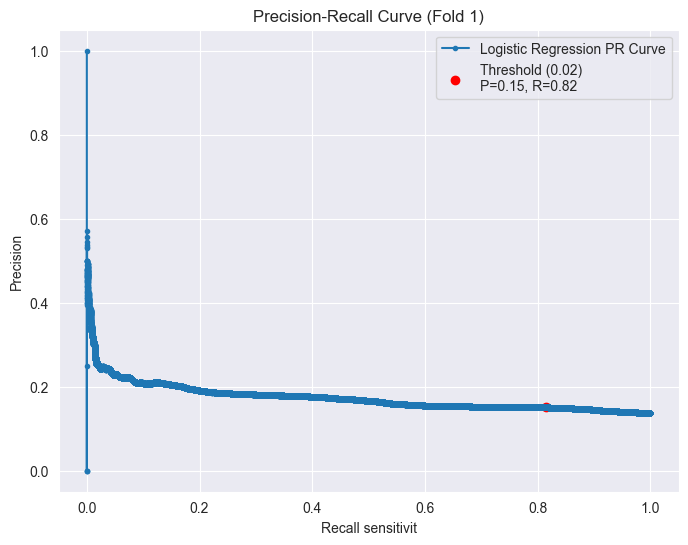


Logistic Regression Metrics Tuned Threshold:
  Accuracy:  0.3476
  Precision: 0.1508
  Recall:    0.8153
  F1-score:  0.2546
  ROC AUC:   0.5727
  Confusion matrix:
[[37489 99518]
 [ 4005 17676]]

Fold 2/3
Train size: 317376, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2023-08-28 23:00:00
Test period : 2023-08-29 00:00:00 to 2024-05-30 11:00:00

Training Logistic Regression

Threshold Tuning (Fold 2)
Best Threshold 0.0837 (F1 Score: 0.3371)

Precision-Recall Curve (Fold 2)


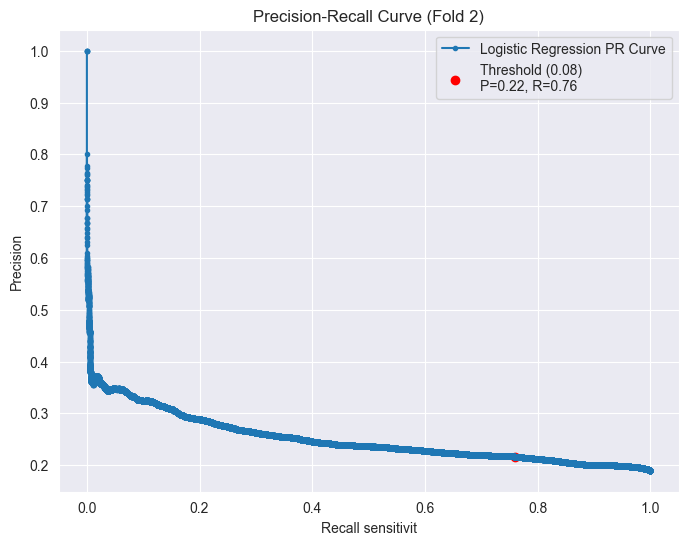


Logistic Regression Metrics Tuned Threshold:
  Accuracy:  0.4348
  Precision: 0.2167
  Recall:    0.7595
  F1-score:  0.3371
  ROC AUC:   0.5914
  Confusion matrix:
[[46188 82470]
 [ 7221 22809]]

Fold 3/3
Train size: 476064, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2024-05-30 11:00:00
Test period : 2024-05-30 12:00:00 to 2025-03-01 23:00:00

Training Logistic Regression

Threshold Tuning (Fold 3)
Best Threshold 0.2524 (F1 Score: 0.4361)

Precision-Recall Curve (Fold 3)


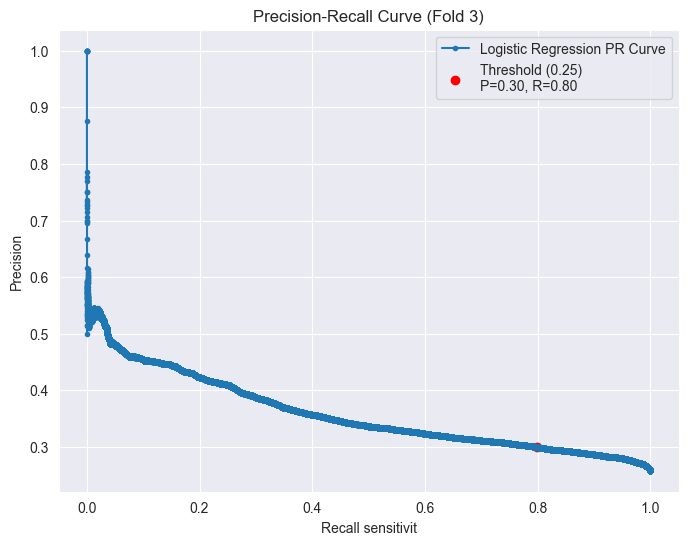


Logistic Regression Metrics Tuned Threshold:
  Accuracy:  0.4675
  Precision: 0.3000
  Recall:    0.7982
  F1-score:  0.4361
  ROC AUC:   0.6241
  Confusion matrix:
[[41499 76245]
 [ 8264 32680]]


In [17]:
fold = 0
for train_index, test_index in tscv.split(X):
    fold += 1
    print(f"\nFold {fold}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {df.iloc[train_index]['hour_start'].min()} to {df.iloc[train_index]['hour_start'].max()}")
    print(f"Test period : {df.iloc[test_index]['hour_start'].min()} to {df.iloc[test_index]['hour_start'].max()}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 3. logistic regression
    print("\nTraining Logistic Regression")
    log_reg = LogisticRegression(max_iter=2000, random_state=1, class_weight='balanced')
    log_reg.fit(X_train, y_train)

    y_pred_log = log_reg.predict(X_test)
    y_pred_log_proba = log_reg.predict_proba(X_test)[:, 1] # and here we need positive probabilities for roc auc


    print(f"\nThreshold Tuning (Fold {fold})")
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_log_proba)
    f1_scores = []
    for precision, recall in zip(precision[:-1], recall[:-1]):
        if precision + recall == 0:
            f1_scores.append(0.0)
        else:
            f1_scores.append(2 * (precision * recall) / (precision + recall)) # f1 formula

    best_f1_idx = np.argmax(np.array(f1_scores))
    best_threshold = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    print(f"Best Threshold {best_threshold:.4f} (F1 Score: {best_f1:.4f})")


    print(f"\nPrecision-Recall Curve (Fold {fold})")
    precision, recall, thresholds_un = precision_recall_curve(y_test, y_pred_log_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Logistic Regression PR Curve')
    chosen_recall = recall[best_f1_idx]
    chosen_precision = precision[best_f1_idx]
    plt.scatter(chosen_recall, chosen_precision, marker='o', color='red',
                label=f'Threshold ({best_threshold:.2f})\nP={chosen_precision:.2f}, R={chosen_recall:.2f}')
    plt.xlabel('Recall sensitivit')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Fold {fold})')
    plt.legend()
    plt.grid(True)
    plt.show()

    y_pred_log_tuned = (y_pred_log_proba >= best_threshold).astype(int)

    print("\nLogistic Regression Metrics Tuned Threshold:")
    acc_log_tuned = accuracy_score(y_test, y_pred_log_tuned)
    prec_log_tuned = precision_score(y_test, y_pred_log_tuned)
    rec_log_tuned = recall_score(y_test, y_pred_log_tuned)
    f1_log_tuned = f1_score(y_test, y_pred_log_tuned)
    cm_log_tuned = confusion_matrix(y_test, y_pred_log_tuned)
    roc_auc_log = roc_auc_score(y_test, y_pred_log_proba) # the same

    print(f"  Accuracy:  {acc_log_tuned:.4f}")
    print(f"  Precision: {prec_log_tuned:.4f}")
    print(f"  Recall:    {rec_log_tuned:.4f}")
    print(f"  F1-score:  {f1_log_tuned:.4f}")
    print(f"  ROC AUC:   {roc_auc_log:.4f}")
    print(f"  Confusion matrix:\n{cm_log_tuned}")

In [18]:
# at such a low threshold, many negative instances are now classified as positive
# this catches most of the real alarms (Recall > 0.75 in all folds)
# because of that, false positives are now huge (99k, 82k, 76k), which affects Precision (down to 0.15, 0.22, 0.30)
# since the majority class is negative, overall accuracy drops significantly
# even though Precision dropped, the increase in recall was so large that F1 score improved
# simply optimizing for F1 is impractical - but we can determine an acceptable threshold value by looking at Precision-Recall curve
# so, during the next two steps we will test threshold = 0.4 and threshold = 0.3

In [19]:
fold = 0
for train_index, test_index in tscv.split(X):
    fold += 1
    print(f"\nFold {fold}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {df.iloc[train_index]['hour_start'].min()} to {df.iloc[train_index]['hour_start'].max()}")
    print(f"Test period : {df.iloc[test_index]['hour_start'].min()} to {df.iloc[test_index]['hour_start'].max()}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 3. logistic regression
    print("\nTraining Logistic Regression")
    log_reg = LogisticRegression(max_iter=2000, random_state=1, class_weight='balanced')
    log_reg.fit(X_train, y_train)

    y_pred_log = log_reg.predict(X_test)
    y_pred_log_proba = log_reg.predict_proba(X_test)[:, 1] # and here we need positive probabilities for roc auc

    y_pred_log_th4 = (y_pred_log_proba >= 0.4).astype(int) # test with 0.4

    # Evaluate Logistic Regression
    acc_log = accuracy_score(y_test, y_pred_log_th4)
    prec_log = precision_score(y_test, y_pred_log_th4)
    rec_log = recall_score(y_test, y_pred_log_th4)
    f1_log = f1_score(y_test, y_pred_log_th4)
    cm_log = confusion_matrix(y_test, y_pred_log_th4)
    roc_auc_log = roc_auc_score(y_test, y_pred_log_proba)

    print(f"Logistic Regression Metrics (Fold {fold}):")
    print(f"  Accuracy:  {acc_log:.4f}")
    print(f"  Precision: {prec_log:.4f}")
    print(f"  Recall:    {rec_log:.4f}")
    print(f"  F1-score:  {f1_log:.4f}")
    print(f"  ROC AUC:   {roc_auc_log:.4f}")
    print(f"  Confusion matrix:   {cm_log}")


Fold 1/3
Train size: 158688, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2022-11-26 11:00:00
Test period : 2022-11-26 12:00:00 to 2023-08-28 23:00:00

Training Logistic Regression
Logistic Regression Metrics (Fold 1):
  Accuracy:  0.7475
  Precision: 0.1847
  Recall:    0.2484
  F1-score:  0.2118
  ROC AUC:   0.5727
  Confusion matrix:   [[113230  23777]
 [ 16296   5385]]

Fold 2/3
Train size: 317376, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2023-08-28 23:00:00
Test period : 2023-08-29 00:00:00 to 2024-05-30 11:00:00

Training Logistic Regression
Logistic Regression Metrics (Fold 2):
  Accuracy:  0.7195
  Precision: 0.2670
  Recall:    0.2762
  F1-score:  0.2715
  ROC AUC:   0.5914
  Confusion matrix:   [[105887  22771]
 [ 21737   8293]]

Fold 3/3
Train size: 476064, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2024-05-30 11:00:00
Test period : 2024-05-30 12:00:00 to 2025-03-01 23:00:00

Training Logistic Regression
Logistic Regression Metrics (Fold 

In [20]:
fold = 0
for train_index, test_index in tscv.split(X):
    fold += 1
    print(f"\nFold {fold}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {df.iloc[train_index]['hour_start'].min()} to {df.iloc[train_index]['hour_start'].max()}")
    print(f"Test period : {df.iloc[test_index]['hour_start'].min()} to {df.iloc[test_index]['hour_start'].max()}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 3. logistic regression
    print("\nTraining Logistic Regression")
    log_reg = LogisticRegression(max_iter=2000, random_state=1, class_weight='balanced')
    log_reg.fit(X_train, y_train)

    y_pred_log = log_reg.predict(X_test)
    y_pred_log_proba = log_reg.predict_proba(X_test)[:, 1] # and here we need positive probabilities for roc auc

    y_pred_log_th3 = (y_pred_log_proba >= 0.3).astype(int)  # test with 0.3

    acc_log = accuracy_score(y_test, y_pred_log_th3)
    prec_log = precision_score(y_test, y_pred_log_th3)
    rec_log = recall_score(y_test, y_pred_log_th3)
    f1_log = f1_score(y_test, y_pred_log_th3)
    cm_log = confusion_matrix(y_test, y_pred_log_th3)
    roc_auc_log = roc_auc_score(y_test, y_pred_log_proba)

    print(f"Logistic Regression Metrics (Fold {fold}):")
    print(f"  Accuracy:  {acc_log:.4f}")
    print(f"  Precision: {prec_log:.4f}")
    print(f"  Recall:    {rec_log:.4f}")
    print(f"  F1-score:  {f1_log:.4f}")
    print(f"  ROC AUC:   {roc_auc_log:.4f}")
    print(f"  Confusion matrix:   {cm_log}")


Fold 1/3
Train size: 158688, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2022-11-26 11:00:00
Test period : 2022-11-26 12:00:00 to 2023-08-28 23:00:00

Training Logistic Regression
Logistic Regression Metrics (Fold 1):
  Accuracy:  0.7112
  Precision: 0.1806
  Recall:    0.3148
  F1-score:  0.2295
  ROC AUC:   0.5727
  Confusion matrix:   [[106036  30971]
 [ 14856   6825]]

Fold 2/3
Train size: 317376, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2023-08-28 23:00:00
Test period : 2023-08-29 00:00:00 to 2024-05-30 11:00:00

Training Logistic Regression
Logistic Regression Metrics (Fold 2):
  Accuracy:  0.6687
  Precision: 0.2506
  Recall:    0.3773
  F1-score:  0.3012
  ROC AUC:   0.5914
  Confusion matrix:   [[94778 33880]
 [18699 11331]]

Fold 3/3
Train size: 476064, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2024-05-30 11:00:00
Test period : 2024-05-30 12:00:00 to 2025-03-01 23:00:00

Training Logistic Regression
Logistic Regression Metrics (Fold 3):


In [ ]:
"""
comparing the thresholds (using Fold 3 as the most recent data):

threshold = 0.5:
  recall: 0.54 (misses almost half the alarms)
  precision: 0.33 (about 1 in 3 alarm predictions are correct)
  F1-Score: 0.41

threshold = 0.4:
  recall: 0.64 (catches significantly more alarms than 0.5)
  precision: 0.32 (slightly lower, still about 1 in 3 correct)
  F1-Score: 0.43

threshold = 0.3:
  recall: 0.75 (catches the most alarms - 3 out of 4)
  precision: 0.30 (slightly lower, still about 1 in 3 correct)
  F1-Score: 0.43

moving from threshold 0.5 to 0.3 gives a large boost
in Recall (+21%) with minimal loss in Precision (-3%)
accuracy drops from 0.60 to 0.49, but in our case
it can be misleading (alarms are rare, so dataset is imbalanced)

threshold 0.3 appears to be the best choice among these options.
it maximizes the Recall (0.75), meaning it detects the highest
percentage of actual alarms, and achieves highest F1-score

this comes at the cost of low Precision (0.31). while not ideal,
the benefit of catching 75% of real events might outweigh the cost
of false alarms in our context (missing at an actual alarm is likely
worse than predicting an alarm that didn’t happen)
"""

In [21]:
lin_reg_coef = []
log_reg_coef = []

fold = 0
for train_index, test_index in tscv.split(X):
    fold += 1
    print(f"\nFold {fold}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {df.iloc[train_index]['hour_start'].min()} to {df.iloc[train_index]['hour_start'].max()}")
    print(f"Test period : {df.iloc[test_index]['hour_start'].min()} to {df.iloc[test_index]['hour_start'].max()}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 2. linear regression
    print("\nTraining Linear Regression")
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_pred_lin_cont = lin_reg.predict(X_test)
    # lin reg predicts a continuous numerical value, we use thresholding to convert it into a binary answer
    y_pred_lin_bin = (y_pred_lin_cont > 0.5).astype(int)

    mse_lin = mean_squared_error(y_test, y_pred_lin_cont) # specific for lin reg
    acc_lin = accuracy_score(y_test, y_pred_lin_bin)
    prec_lin = precision_score(y_test, y_pred_lin_bin)
    rec_lin = recall_score(y_test, y_pred_lin_bin)
    cm_lin = confusion_matrix(y_test, y_pred_lin_bin)
    f1_lin = f1_score(y_test, y_pred_lin_bin)
    roc_auc_lin = roc_auc_score(y_test, y_pred_lin_cont)

    print(f"Linear Regression Metrics (Fold {fold}):")
    print(f"  Mean squared error:  {mse_lin:.4f}")
    print(f"  Accuracy:  {acc_lin:.4f}")
    print(f"  Precision: {prec_lin:.4f}")
    print(f"  Recall:    {rec_lin:.4f}")
    print(f"  F1-score:  {f1_lin:.4f}")
    print(f"  ROC AUC:   {roc_auc_lin}")
    print(f"  Confusion matrix:   {cm_lin}")

    # 3. logistic regression
    print("\nTraining Logistic Regression")
    log_reg = LogisticRegression(max_iter=2000, random_state=1, class_weight='balanced')
    log_reg.fit(X_train, y_train)

    y_pred_log = log_reg.predict(X_test)
    y_pred_log_proba = log_reg.predict_proba(X_test)[:, 1] # and here we need positive probabilities for roc auc

    y_pred_log_th3 = (y_pred_log_proba >= 0.3).astype(int)

    acc_log = accuracy_score(y_test, y_pred_log_th3)
    prec_log = precision_score(y_test, y_pred_log_th3)
    rec_log = recall_score(y_test, y_pred_log_th3)
    f1_log = f1_score(y_test, y_pred_log_th3)
    cm_log = confusion_matrix(y_test, y_pred_log_th3)
    roc_auc_log = roc_auc_score(y_test, y_pred_log_proba)

    print(f"Logistic Regression Metrics (Fold {fold}):")
    print(f"  Accuracy:  {acc_log:.4f}")
    print(f"  Precision: {prec_log:.4f}")
    print(f"  Recall:    {rec_log:.4f}")
    print(f"  F1-score:  {f1_log:.4f}")
    print(f"  ROC AUC:   {roc_auc_log:.4f}")
    print(f"  Confusion matrix:   {cm_log}")

    lin_reg_coef.append(lin_reg.coef_)
    log_reg_coef.append(log_reg.coef_[0])


Fold 1/3
Train size: 158688, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2022-11-26 11:00:00
Test period : 2022-11-26 12:00:00 to 2023-08-28 23:00:00

Training Linear Regression
Linear Regression Metrics (Fold 1):
  Mean squared error:  0.2259
  Accuracy:  0.8537
  Precision: 0.2329
  Recall:    0.0308
  F1-score:  0.0543
  ROC AUC:   0.5588170189773888
  Confusion matrix:   [[134810   2197]
 [ 21014    667]]

Training Logistic Regression
Logistic Regression Metrics (Fold 1):
  Accuracy:  0.7112
  Precision: 0.1806
  Recall:    0.3148
  F1-score:  0.2295
  ROC AUC:   0.5727
  Confusion matrix:   [[106036  30971]
 [ 14856   6825]]

Fold 2/3
Train size: 317376, Test size: 158688
Train period: 2022-02-24 00:00:00 to 2023-08-28 23:00:00
Test period : 2023-08-29 00:00:00 to 2024-05-30 11:00:00

Training Linear Regression
Linear Regression Metrics (Fold 2):
  Mean squared error:  0.2136
  Accuracy:  0.8107
  Precision: 0.4724
  Recall:    0.0020
  F1-score:  0.0040
  ROC AUC:   0

In [22]:
avg_lin_coef = np.mean(lin_reg_coef, axis=0)
avg_log_coef = np.mean(log_reg_coef, axis=0)

In [23]:
df_avg_lr = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": avg_lin_coef,
    "Absolute": np.abs(avg_lin_coef)
})
df_avg_lr_top20 = df_avg_lr.sort_values(by="Absolute", ascending=False).head(20)

In [24]:
df_avg_log = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": avg_log_coef,
    "Absolute": np.abs(avg_log_coef)
})
df_avg_log_top20 = df_avg_log.sort_values(by="Absolute", ascending=False).head(20)

In [25]:
df_avg_lr_top20

,Feature,Coefficient,Absolute
22,sunrise_seconds,-0.154009,0.154009
23,sunset_seconds,-0.135869,0.135869
4,temp,-0.076975,0.076975
2,dew,0.056010,0.056010
9,humidity,-0.050861,0.050861
50,svd_comp_26,0.039773,0.039773
35,svd_comp_11,-0.036678,0.036678
24,daylight_duration_seconds,-0.032781,0.032781
49,svd_comp_25,-0.031222,0.031222
26,svd_comp_2,0.028171,0.028171


In [26]:
df_avg_log_top20

,Feature,Coefficient,Absolute
22,sunrise_seconds,-1.380209,1.380209
23,sunset_seconds,-1.219477,1.219477
4,temp,-0.831973,0.831973
2,dew,0.623487,0.623487
9,humidity,-0.526988,0.526988
50,svd_comp_26,0.359871,0.359871
1,time_since_last_alarm_end_minutes,-0.325542,0.325542
35,svd_comp_11,-0.322070,0.322070
49,svd_comp_25,-0.294727,0.294727
24,daylight_duration_seconds,-0.294508,0.294508


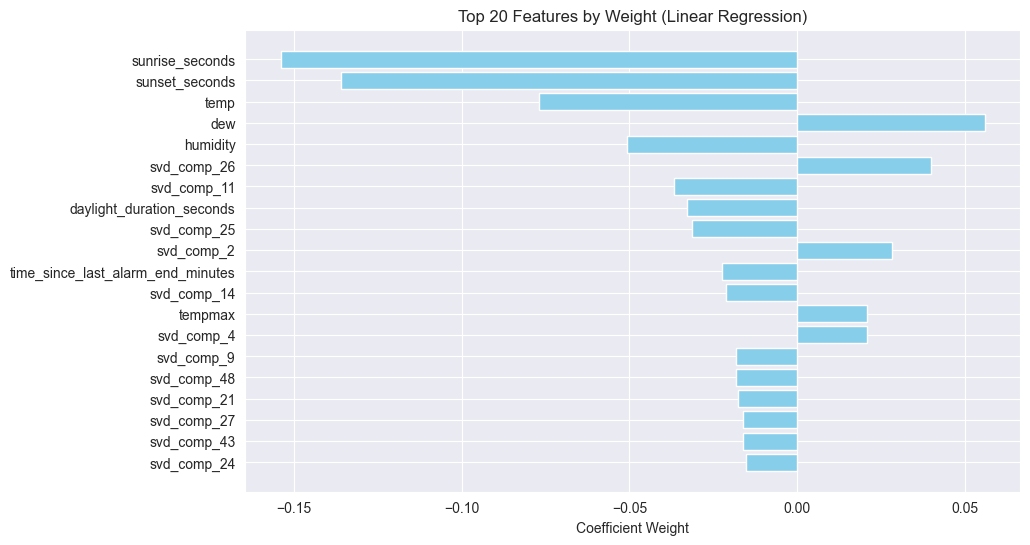

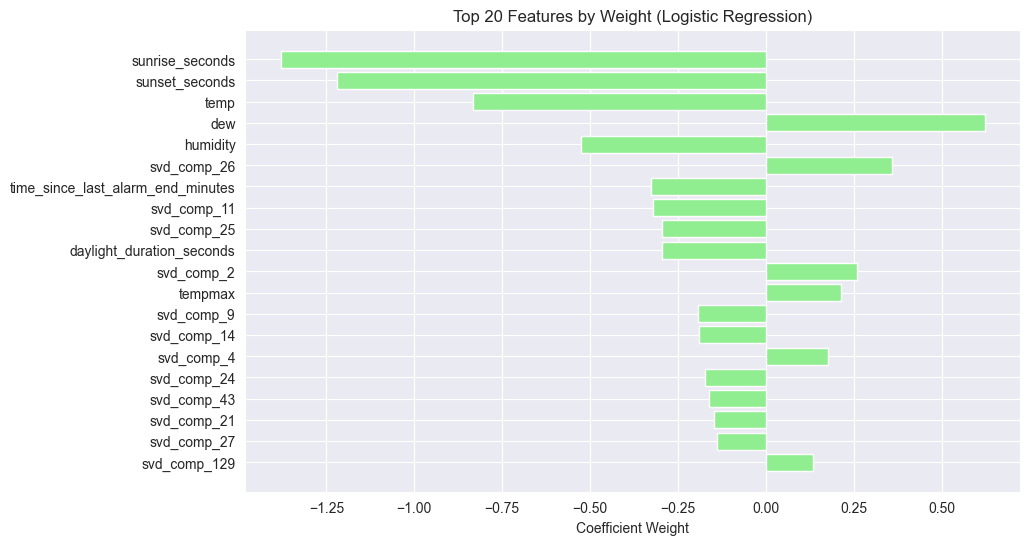

In [27]:
plt.figure(figsize=(10, 6))
plt.barh(df_avg_lr_top20["Feature"], df_avg_lr_top20["Coefficient"], color='skyblue')
plt.xlabel("Coefficient Weight")
plt.title("Top 20 Features by Weight (Linear Regression)")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(df_avg_log_top20["Feature"], df_avg_log_top20["Coefficient"], color='lightgreen')
plt.xlabel("Coefficient Weight")
plt.title("Top 20 Features by Weight (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
"""
sunrise_seconds, sunset_seconds, daylight_duration_seconds (all negative):
the most important features, as these increase (later sunrise/sunset)
the probability of an alarm decreases

temp, humidity (negative):
higher average temperature and humidity connect
with a lower probability of alarms

dew (positive):
higher dew connects with a higher probability of alarms

svd_comp_ (varies):
content of the ISW captured by SVD provides significant predictive information

time_since_last_alarm_end_minutes (negative):
the longer the time since the last alarm ended, the lower
the probability of a new alarm starting right now
"""